In [1]:
# import general packages
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

import dill
import multiprocessing as mp
from tqdm import tqdm

In [2]:
# Import stochastic model from repository
import os
import sys
sys.path.append('..')
from SC_models.mutation import clonal_evolution

In [3]:
# Create path for exporting fit plots
path = '../Plots/Mutation CBD/'
if not os.path.exists(path):
    os.makedirs(path)

# Modelling the evolution of mutations acquired in SCs

100%|██████████| 10000/10000 [04:58<00:00, 33.50it/s]


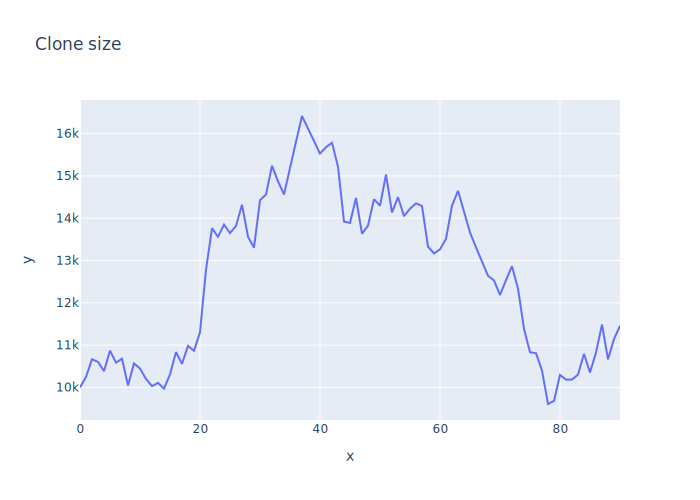

In [5]:
# Set number of initial cells to be simulated
init_cells = 10_000
init_tmax = [90]*init_cells

# Fit trajectories for each participant with multiprocessing.
np.random.seed(123)
if __name__ == '__main__':
    with mp.Pool() as p:
        clone_track = list(tqdm(p.imap(clonal_evolution, init_tmax), total=len(init_tmax)))


# Compute total number of cells in the system at each year
total_cells = np.array([clone[:, 0] for clone in clone_track])
total_cells = total_cells.sum(axis=0)

# Plot total cells in the system
fig_total_cells = px.line(title='Clone size',
                          x=list(range(total_cells.shape[0])),
                          y=total_cells)

fig_total_cells.show(renderer='svg')

In [6]:
with open('../Resources/CDB mutations.dill', 'wb') as outfile:
    dill.dump(clone_track, outfile)

# Plots

In [4]:
with open('../Resources/CDB mutations.dill', 'rb') as infile:
    clone_track = dill.load(infile)

## Random selection of cells

In [5]:
def delete_ghosts (clone):
    idx = np.argwhere(np.all(clone[..., :] == 0, axis=0))
    filter_clone = np.delete(clone, idx, axis=1)
    return filter_clone

def filter_clone (clone):
    # Filter ages until extinction time
    extinction_time = (clone[:,0]==0).argmax()
    if extinction_time > 0:
        filtered_clone = clone[:extinction_time+1,:]
    else:
        filtered_clone = clone
    return filtered_clone

# Single initial cell trajectory

In [16]:
clone[:,0]

array([1.0, 3.0, 10.0, 15.0, 10.0, 12.0, 8.0, 10.0, 9.0, 11.0, 21.0, 23.0,
       25.0, 41.0, 35.0, 39.0, 38.0, 35.0, 40.0, 25.0, 48.0, 61.0, 55.0,
       51.0, 40.0, 49.0, 35.0, 38.0, 34.0, 17.0, 19.0, 19.0, 14.0, 17.0,
       4.0, 2.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0], dtype=object)

In [55]:
filter_track = [clone for clone in clone_track if clone.shape[1]>1]


clone = filter_track[0]

filtered_clone = filter_clone (clone)
filtered_clone = delete_ghosts (filtered_clone)
mutations = filtered_clone[:,1:]
max_year = mutations.shape[0] -1

fig = go.Figure()
x = np.linspace(0, max_year, max_year+1)
# add jitter to mutations:
#mutations = mutations + np.random.normal(scale=0.5, size=mutations.shape)

# add_ total_cells
fig.add_trace(
    go.Scatter(x =x, y = filtered_clone[:,0], mode='lines', fill='tozeroy', fillcolor='rgba(184, 247, 212,0.3)',
               line=dict(width=1,color='rgb(184, 247, 212)'),
               name='total cells'))


fig.add_trace(
    go.Scatter(x=[0], y=[0],
               mode='lines',
               line=dict(color="Black"),
               name='Genetic Variants',
              # legendgroup_text='hola',
               legendgroup='Genetic variants'))

for col in range(mutations.shape[1]):
    fig.add_trace(
        go.Scatter(x=x, y=mutations[:, col], mode='lines', showlegend=False))


fig.update_layout(template='plotly_white',
                  title='Stochastic evolution of genetic clones from initial HSC',
                  xaxis_title='Years',
                  yaxis_title='Cell counts')
fig.write_image(path + 'single_cell_evolution.png', scale=5)
fig.show()

In [15]:
fig = go.Figure()

filter_track = [clone for clone in clone_track if clone.shape[1]>1]
for clone in filter_track:
    filtered_clone = filter_clone (clone)
    filtered_clone = delete_ghosts (filtered_clone)
    mutations = filtered_clone[:,1:]
    max_year = mutations.shape[0] -1
    x = np.linspace(0, max_year, max_year+1)
    # add jitter to mutations:
    #mutations = mutations + np.random.normal(scale=0.5, size=mutations.shape)
    
    for col in range(mutations.shape[1]):
        fig.add_trace(
            go.Scatter(x=x, y=mutations[:, col], mode='lines', showlegend=False))

fig.update_layout(template='plotly_white',
                  title='Evolution of neutral clones',
                  xaxis_title='Years',
                  yaxis_title='Cell counts')
fig.write_image(path + '10_000_SC_simulation.png', scale=5)

# Simulating the effect of SC on VAF evolution

In [12]:
N_cells = 10_000

fig = go.Figure()

filter_track = [clone for clone in clone_track if clone.shape[1]>1]
for clone in filter_track:
    filtered_clone = filter_clone (clone)
    filtered_clone = delete_ghosts (filtered_clone)
    mutations = filtered_clone[:,1:]
    max_year = mutations.shape[0] -1
    x = np.linspace(0, max_year, max_year+1)
    # add jitter to mutations:
    #mutations = mutations + np.random.normal(scale=0.5, size=mutations.shape)
    
    for col in range(mutations.shape[1]):
        fig.add_trace(
            go.Scatter(x=x, y=mutations[:, col]/(2*N_cells), mode='lines', showlegend=False))

# horizontal sequencing threshold
fig.add_hrect(y0=0, y1=0.01, line_width=0, fillcolor="red", opacity=0.2)


fig.update_layout(template='plotly_white',
                  title='Evolution of neutral clones',
                  xaxis_title='Years',
                  yaxis_title='VAF',
                  yaxis_range=[0,0.05])

fig.write_image(path + '10_000_VAF.png', scale=5)

In [13]:
N_cells = 100_000

fig = go.Figure()

filter_track = [clone for clone in clone_track if clone.shape[1]>1]
for clone in filter_track:
    filtered_clone = filter_clone (clone)
    filtered_clone = delete_ghosts (filtered_clone)
    mutations = filtered_clone[:,1:]
    max_year = mutations.shape[0] -1
    x = np.linspace(0, max_year, max_year+1)
    # add jitter to mutations:
    #mutations = mutations + np.random.normal(scale=0.5, size=mutations.shape)
    
    for col in range(mutations.shape[1]):
        fig.add_trace(
            go.Scatter(x=x, y=mutations[:, col]/(2*N_cells), mode='lines', showlegend=False))

# horizontal sequencing threshold
fig.add_hrect(y0=0, y1=0.01, line_width=0, fillcolor="red", opacity=0.2)

        
        
fig.update_layout(template='plotly_white',
                  title='Evolution of neutral clones',
                  xaxis_title='Years',
                  yaxis_title='VAF',
                  yaxis_range=[0,0.05])

fig.write_image(path + '100_000_VAF.png', scale=5)

In [14]:
N_cells = 6_000

fig = go.Figure()

filter_track = [clone for clone in clone_track if clone.shape[1]>1]
for clone in filter_track:
    filtered_clone = filter_clone (clone)
    filtered_clone = delete_ghosts (filtered_clone)
    mutations = filtered_clone[:,1:]
    max_year = mutations.shape[0] -1
    x = np.linspace(0, max_year, max_year+1)
    # add jitter to mutations:
    #mutations = mutations + np.random.normal(scale=0.5, size=mutations.shape)
    
    for col in range(mutations.shape[1]):
        fig.add_trace(
            go.Scatter(x=x, y=mutations[:, col]/(2*N_cells), mode='lines', showlegend=False))

# horizontal sequencing threshold
fig.add_hrect(y0=0, y1=0.01, line_width=0, fillcolor="red", opacity=0.2)

fig.update_layout(template='plotly_white',
                  title='Evolution of neutral clones',
                  xaxis_title='Years',
                  yaxis_title='VAF',
                  yaxis_range=[0,0.05])
fig.write_image(path + '6_000_VAF.png', scale=5)

In [57]:
N_cells = 385

fig = go.Figure()

filter_track = [clone for clone in clone_track if clone.shape[1]>1]
for clone in filter_track:
    filtered_clone = filter_clone (clone)
    filtered_clone = delete_ghosts (filtered_clone)
    mutations = filtered_clone[:,1:]
    max_year = mutations.shape[0] -1
    x = np.linspace(0, max_year, max_year+1)
    # add jitter to mutations:
    #mutations = mutations + np.random.normal(scale=0.5, size=mutations.shape)
    
    for col in range(mutations.shape[1]):
        fig.add_trace(
            go.Scatter(x=x, y=mutations[:, col]/(2*N_cells), mode='lines', showlegend=False))

# horizontal sequencing threshold
fig.add_hrect(y0=0, y1=0.01, line_width=0, fillcolor="red", opacity=0.2)

fig.update_layout(template='plotly_white',
                  title='Evolution of neutral clones',
                  xaxis_title='Years',
                  yaxis_title='VAF',
                  yaxis_range=[0,0.05])
fig.write_image(path + '385_VAF.png', scale=5)